# Image Colorization using Optimization

## Imports

In [1]:
%matplotlib inline

import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Load Image

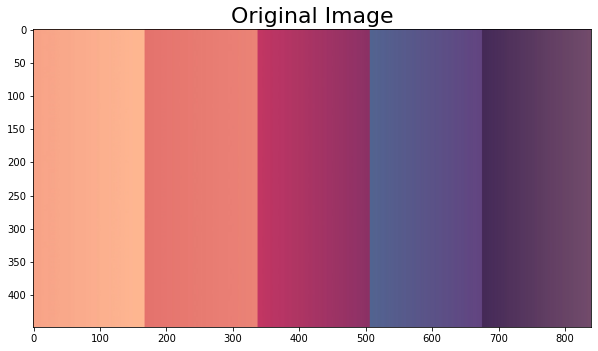

In [174]:
orig_img = cv2.cvtColor(cv2.imread("images/gradients.jpg"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Original Image", {'fontsize':22})
plt.imshow(orig_img)

## Convert to Grayscale

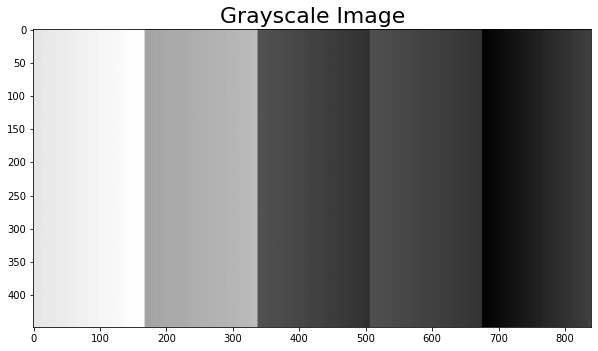

In [175]:
grayscale_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10, 10))
plt.title("Grayscale Image", {'fontsize':22})
plt.imshow(grayscale_img, cmap='gray')

## UI: Image Colorization Setup

### Step 1: Choose a color

In [176]:
from IPython import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='black',
    disabled=False
)
display.display(color_picker)

ColorPicker(value='black', description='Pick a color')

### Step 2: Place Markings

If it doesn't get you to the drawing mode, then rerun this function again.

============================================   NOTICE   ============================================

You do not need to rerun this cell or the last to add another color!
Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.


<IPython.core.display.Javascript object>


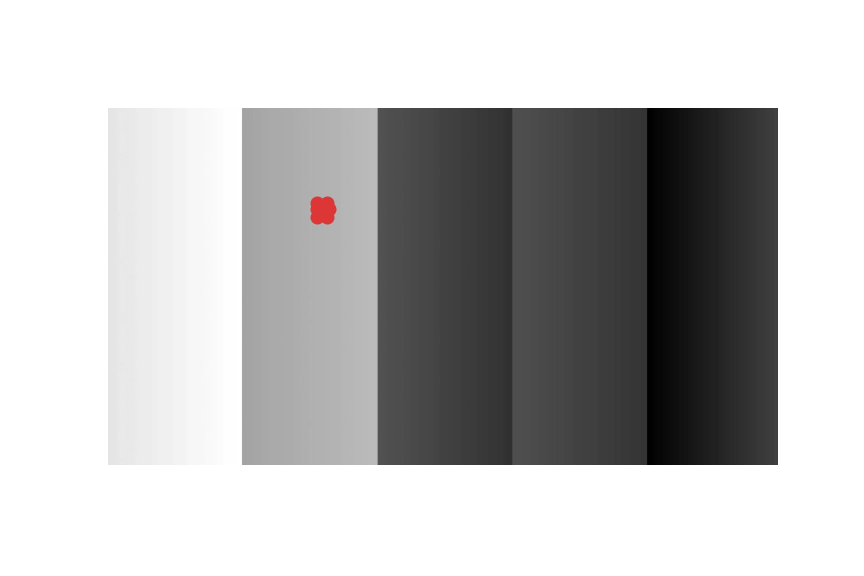

In [192]:
%matplotlib notebook

my_color = color_picker.value

def mark_image(img):
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    print("\n============================================   NOTICE   ============================================\n")
    print("You do not need to rerun this cell or the last to add another color!")
    print("Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.")
    fig = plt.figure()
    fig.set_label('Mark the spots to color')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plot_points = []

    def on_mouse_pressed(event):
        my_color = color_picker.value
        x = event.xdata
        y = event.ydata
        plot_points.append((x, y, my_color))
        plt.plot(x, y, c=my_color, marker='o')
        
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)

    return plot_points

plot_points = mark_image(grayscale_img)

### Step 3: Add Markings to grayscale image

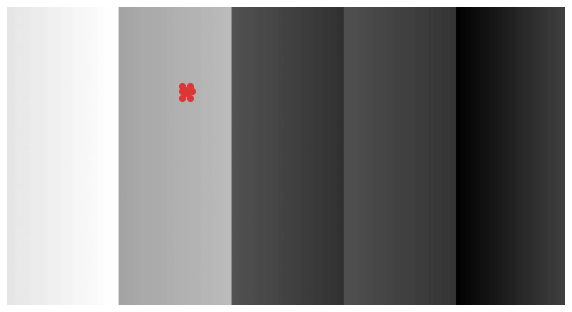

In [193]:
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')
for pt in plot_points:
    x, y, color = pt
    plt.plot(x, y, c=color, marker='o')
plt.savefig("output/marked_img.jpg", bbox_inches='tight', pad_inches=0, dpi=500)
marked_img = cv2.cvtColor(cv2.imread("output/marked_img.jpg"), cv2.COLOR_BGR2RGB)

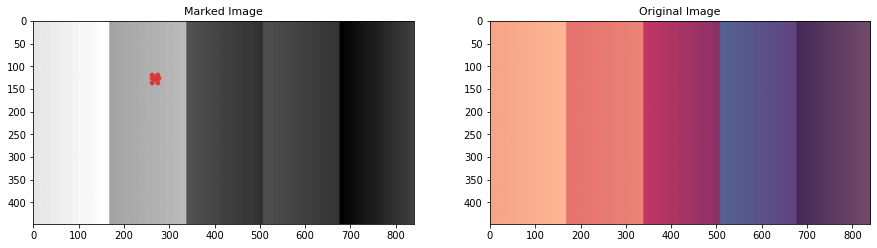

In [194]:
marked_img = cv2.resize(marked_img, (orig_img.shape[1], orig_img.shape[0]))

fig = plt.figure(figsize=(15, 15))
plt.subplot(122)
plt.title("Original Image", {'fontsize':11})
plt.imshow(orig_img)

plt.subplot(121)
plt.title("Marked Image", {'fontsize':11})
plt.imshow(marked_img)

In [133]:
def getWindowPixels(row, col):
    row_start = row - 1
    row_end = row + 2
    col_start = col - 1
    col_end = col + 2

    if row_start < 0:
        row_start = 0 
    if row_end >= height:
        row_end = height
    if col_start < 0:
        col_start = 0 
    if col_end >= width:
        col_end = width
    
    pixels = []
        
    for i in range(row_start, row_end):
        for j in range(col_start, col_end):
            if i != row or j != col:
                pixels.append((i, j))
                
    return pixels

In [195]:
yuv_image = cv2.cvtColor(marked_img, cv2.COLOR_RGB2YUV)

variances = np.zeros((yuv_image.shape[0], yuv_image.shape[1]), dtype='uint8')
means = np.zeros(variances.shape, dtype='uint8')

height = variances.shape[0]
width = variances.shape[1]

# Calculate variances and mean for pixel windows
for row in range(height):
    if (row % 50 == 0):
        print("At row " + str(row))
    for col in range(width):       
        
        
        window = getWindowPixels(row, col)
        window_y_values = []
        
        for pixel in window:
            window_y_values.append(yuv_image[pixel[0], pixel[1]])
        
        variances[row, col] = np.var(window_y_values)
        means[row, col] = np.mean(window_y_values)
        

            

At row 0
At row 50
At row 100
At row 150
At row 200
At row 250
At row 300
At row 350
At row 400


In [196]:
weights = {}

for row in range(height):
    if row % 10 == 0:
        print("Row: " + str(row))
    for col in range(width):
        neighboring_pixels = getWindowPixels(row, col)
        for pixel in neighboring_pixels:
            y_value = yuv_image[row, col, 0]
            
            weight = 1 + (1 / pow(variances[row, col], 2)) * (yuv_image[row, col, 0] - means[row, col]) * (yuv_image[row, col, 0] - means[pixel[0], pixel[1]])
            
            weights[((row, col), pixel)] = weight
            

Row: 0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  # This is added back by InteractiveShellApp.init_path()


Row: 10
Row: 20
Row: 30
Row: 40
Row: 50
Row: 60
Row: 70
Row: 80
Row: 90
Row: 100
Row: 110
Row: 120
Row: 130
Row: 140
Row: 150
Row: 160
Row: 170
Row: 180
Row: 190
Row: 200
Row: 210
Row: 220
Row: 230
Row: 240
Row: 250
Row: 260
Row: 270
Row: 280
Row: 290
Row: 300
Row: 310
Row: 320
Row: 330
Row: 340
Row: 350
Row: 360
Row: 370
Row: 380
Row: 390
Row: 400
Row: 410
Row: 420
Row: 430
Row: 440


In [197]:
for row in range(height):
    for col in range(width):
        others = getWindowPixels(row, col)
        
        weightSum = 0
        
        for pixel in others:
            toAdd = weights[((row, col), (pixel[0], pixel[1]))]
            if math.isnan(toAdd):
                continue
            weightSum += weights[((row, col), (pixel[0], pixel[1]))]
            
        for pixel in others:
            weights[((row, col), (pixel[0], pixel[1]))] /= weightSum
            
testList = getWindowPixels(171,250)


for pixel in testList:
    print(weights[(171, 250), (pixel[0], pixel[1])])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


0.12499999999999997
0.12499999999999997
0.12499999999999997
0.12499999999999997
0.12499999999999997
0.12499999999999997
0.12499999999999997
0.12499999999999997


In [147]:
import math

for key in weights.keys():
    if math.isnan(weights[key]):
        print("Found Nan at: " + str(key))

Found Nan at: ((2, 366), (1, 365))
Found Nan at: ((2, 366), (1, 366))
Found Nan at: ((2, 366), (1, 367))
Found Nan at: ((2, 366), (2, 365))
Found Nan at: ((2, 366), (2, 367))
Found Nan at: ((2, 366), (3, 365))
Found Nan at: ((2, 366), (3, 366))
Found Nan at: ((2, 366), (3, 367))
Found Nan at: ((2, 367), (1, 366))
Found Nan at: ((2, 367), (1, 367))
Found Nan at: ((2, 367), (1, 368))
Found Nan at: ((2, 367), (2, 366))
Found Nan at: ((2, 367), (2, 368))
Found Nan at: ((2, 367), (3, 366))
Found Nan at: ((2, 367), (3, 367))
Found Nan at: ((2, 367), (3, 368))
Found Nan at: ((2, 399), (1, 398))
Found Nan at: ((2, 399), (1, 399))
Found Nan at: ((2, 399), (1, 400))
Found Nan at: ((2, 399), (2, 398))
Found Nan at: ((2, 399), (2, 400))
Found Nan at: ((2, 399), (3, 398))
Found Nan at: ((2, 399), (3, 399))
Found Nan at: ((2, 399), (3, 400))
Found Nan at: ((2, 407), (1, 406))
Found Nan at: ((2, 407), (1, 407))
Found Nan at: ((2, 407), (1, 408))
Found Nan at: ((2, 407), (2, 406))
Found Nan at: ((2, 4

Found Nan at: ((64, 392), (63, 391))
Found Nan at: ((64, 392), (63, 392))
Found Nan at: ((64, 392), (63, 393))
Found Nan at: ((64, 392), (64, 391))
Found Nan at: ((64, 392), (64, 393))
Found Nan at: ((64, 392), (65, 391))
Found Nan at: ((64, 392), (65, 392))
Found Nan at: ((64, 392), (65, 393))
Found Nan at: ((65, 14), (64, 13))
Found Nan at: ((65, 14), (64, 14))
Found Nan at: ((65, 14), (64, 15))
Found Nan at: ((65, 14), (65, 13))
Found Nan at: ((65, 14), (65, 15))
Found Nan at: ((65, 14), (66, 13))
Found Nan at: ((65, 14), (66, 14))
Found Nan at: ((65, 14), (66, 15))
Found Nan at: ((65, 378), (64, 377))
Found Nan at: ((65, 378), (64, 378))
Found Nan at: ((65, 378), (64, 379))
Found Nan at: ((65, 378), (65, 377))
Found Nan at: ((65, 378), (65, 379))
Found Nan at: ((65, 378), (66, 377))
Found Nan at: ((65, 378), (66, 378))
Found Nan at: ((65, 378), (66, 379))
Found Nan at: ((66, 440), (65, 439))
Found Nan at: ((66, 440), (65, 440))
Found Nan at: ((66, 440), (65, 441))
Found Nan at: ((6

Found Nan at: ((101, 98), (100, 98))
Found Nan at: ((101, 98), (100, 99))
Found Nan at: ((101, 98), (101, 97))
Found Nan at: ((101, 98), (101, 99))
Found Nan at: ((101, 98), (102, 97))
Found Nan at: ((101, 98), (102, 98))
Found Nan at: ((101, 98), (102, 99))
Found Nan at: ((101, 103), (100, 102))
Found Nan at: ((101, 103), (100, 103))
Found Nan at: ((101, 103), (100, 104))
Found Nan at: ((101, 103), (101, 102))
Found Nan at: ((101, 103), (101, 104))
Found Nan at: ((101, 103), (102, 102))
Found Nan at: ((101, 103), (102, 103))
Found Nan at: ((101, 103), (102, 104))
Found Nan at: ((101, 132), (100, 131))
Found Nan at: ((101, 132), (100, 132))
Found Nan at: ((101, 132), (100, 133))
Found Nan at: ((101, 132), (101, 131))
Found Nan at: ((101, 132), (101, 133))
Found Nan at: ((101, 132), (102, 131))
Found Nan at: ((101, 132), (102, 132))
Found Nan at: ((101, 132), (102, 133))
Found Nan at: ((101, 502), (100, 501))
Found Nan at: ((101, 502), (100, 502))
Found Nan at: ((101, 502), (100, 503))


Found Nan at: ((128, 444), (129, 444))
Found Nan at: ((128, 444), (129, 445))
Found Nan at: ((128, 485), (127, 484))
Found Nan at: ((128, 485), (127, 485))
Found Nan at: ((128, 485), (127, 486))
Found Nan at: ((128, 485), (128, 484))
Found Nan at: ((128, 485), (128, 486))
Found Nan at: ((128, 485), (129, 484))
Found Nan at: ((128, 485), (129, 485))
Found Nan at: ((128, 485), (129, 486))
Found Nan at: ((128, 838), (127, 837))
Found Nan at: ((128, 838), (127, 838))
Found Nan at: ((128, 838), (127, 839))
Found Nan at: ((128, 838), (128, 837))
Found Nan at: ((128, 838), (128, 839))
Found Nan at: ((128, 838), (129, 837))
Found Nan at: ((128, 838), (129, 838))
Found Nan at: ((128, 838), (129, 839))
Found Nan at: ((129, 229), (128, 228))
Found Nan at: ((129, 229), (128, 229))
Found Nan at: ((129, 229), (128, 230))
Found Nan at: ((129, 229), (129, 228))
Found Nan at: ((129, 229), (129, 230))
Found Nan at: ((129, 229), (130, 228))
Found Nan at: ((129, 229), (130, 229))
Found Nan at: ((129, 229)

Found Nan at: ((155, 210), (156, 210))
Found Nan at: ((155, 210), (156, 211))
Found Nan at: ((155, 243), (154, 242))
Found Nan at: ((155, 243), (154, 243))
Found Nan at: ((155, 243), (154, 244))
Found Nan at: ((155, 243), (155, 242))
Found Nan at: ((155, 243), (155, 244))
Found Nan at: ((155, 243), (156, 242))
Found Nan at: ((155, 243), (156, 243))
Found Nan at: ((155, 243), (156, 244))
Found Nan at: ((155, 505), (154, 504))
Found Nan at: ((155, 505), (154, 505))
Found Nan at: ((155, 505), (154, 506))
Found Nan at: ((155, 505), (155, 504))
Found Nan at: ((155, 505), (155, 506))
Found Nan at: ((155, 505), (156, 504))
Found Nan at: ((155, 505), (156, 505))
Found Nan at: ((155, 505), (156, 506))
Found Nan at: ((156, 205), (155, 204))
Found Nan at: ((156, 205), (155, 205))
Found Nan at: ((156, 205), (155, 206))
Found Nan at: ((156, 205), (156, 204))
Found Nan at: ((156, 205), (156, 206))
Found Nan at: ((156, 205), (157, 204))
Found Nan at: ((156, 205), (157, 205))
Found Nan at: ((156, 205)

Found Nan at: ((186, 798), (187, 798))
Found Nan at: ((186, 798), (187, 799))
Found Nan at: ((186, 799), (185, 798))
Found Nan at: ((186, 799), (185, 799))
Found Nan at: ((186, 799), (185, 800))
Found Nan at: ((186, 799), (186, 798))
Found Nan at: ((186, 799), (186, 800))
Found Nan at: ((186, 799), (187, 798))
Found Nan at: ((186, 799), (187, 799))
Found Nan at: ((186, 799), (187, 800))
Found Nan at: ((186, 800), (185, 799))
Found Nan at: ((186, 800), (185, 800))
Found Nan at: ((186, 800), (185, 801))
Found Nan at: ((186, 800), (186, 799))
Found Nan at: ((186, 800), (186, 801))
Found Nan at: ((186, 800), (187, 799))
Found Nan at: ((186, 800), (187, 800))
Found Nan at: ((186, 800), (187, 801))
Found Nan at: ((186, 801), (185, 800))
Found Nan at: ((186, 801), (185, 801))
Found Nan at: ((186, 801), (185, 802))
Found Nan at: ((186, 801), (186, 800))
Found Nan at: ((186, 801), (186, 802))
Found Nan at: ((186, 801), (187, 800))
Found Nan at: ((186, 801), (187, 801))
Found Nan at: ((186, 801)

Found Nan at: ((195, 812), (194, 812))
Found Nan at: ((195, 812), (194, 813))
Found Nan at: ((195, 812), (195, 811))
Found Nan at: ((195, 812), (195, 813))
Found Nan at: ((195, 812), (196, 811))
Found Nan at: ((195, 812), (196, 812))
Found Nan at: ((195, 812), (196, 813))
Found Nan at: ((196, 785), (195, 784))
Found Nan at: ((196, 785), (195, 785))
Found Nan at: ((196, 785), (195, 786))
Found Nan at: ((196, 785), (196, 784))
Found Nan at: ((196, 785), (196, 786))
Found Nan at: ((196, 785), (197, 784))
Found Nan at: ((196, 785), (197, 785))
Found Nan at: ((196, 785), (197, 786))
Found Nan at: ((196, 791), (195, 790))
Found Nan at: ((196, 791), (195, 791))
Found Nan at: ((196, 791), (195, 792))
Found Nan at: ((196, 791), (196, 790))
Found Nan at: ((196, 791), (196, 792))
Found Nan at: ((196, 791), (197, 790))
Found Nan at: ((196, 791), (197, 791))
Found Nan at: ((196, 791), (197, 792))
Found Nan at: ((196, 792), (195, 791))
Found Nan at: ((196, 792), (195, 792))
Found Nan at: ((196, 792)

Found Nan at: ((202, 783), (203, 782))
Found Nan at: ((202, 783), (203, 783))
Found Nan at: ((202, 783), (203, 784))
Found Nan at: ((202, 784), (201, 783))
Found Nan at: ((202, 784), (201, 784))
Found Nan at: ((202, 784), (201, 785))
Found Nan at: ((202, 784), (202, 783))
Found Nan at: ((202, 784), (202, 785))
Found Nan at: ((202, 784), (203, 783))
Found Nan at: ((202, 784), (203, 784))
Found Nan at: ((202, 784), (203, 785))
Found Nan at: ((202, 788), (201, 787))
Found Nan at: ((202, 788), (201, 788))
Found Nan at: ((202, 788), (201, 789))
Found Nan at: ((202, 788), (202, 787))
Found Nan at: ((202, 788), (202, 789))
Found Nan at: ((202, 788), (203, 787))
Found Nan at: ((202, 788), (203, 788))
Found Nan at: ((202, 788), (203, 789))
Found Nan at: ((202, 789), (201, 788))
Found Nan at: ((202, 789), (201, 789))
Found Nan at: ((202, 789), (201, 790))
Found Nan at: ((202, 789), (202, 788))
Found Nan at: ((202, 789), (202, 790))
Found Nan at: ((202, 789), (203, 788))
Found Nan at: ((202, 789)

Found Nan at: ((209, 790), (208, 789))
Found Nan at: ((209, 790), (208, 790))
Found Nan at: ((209, 790), (208, 791))
Found Nan at: ((209, 790), (209, 789))
Found Nan at: ((209, 790), (209, 791))
Found Nan at: ((209, 790), (210, 789))
Found Nan at: ((209, 790), (210, 790))
Found Nan at: ((209, 790), (210, 791))
Found Nan at: ((209, 791), (208, 790))
Found Nan at: ((209, 791), (208, 791))
Found Nan at: ((209, 791), (208, 792))
Found Nan at: ((209, 791), (209, 790))
Found Nan at: ((209, 791), (209, 792))
Found Nan at: ((209, 791), (210, 790))
Found Nan at: ((209, 791), (210, 791))
Found Nan at: ((209, 791), (210, 792))
Found Nan at: ((209, 799), (208, 798))
Found Nan at: ((209, 799), (208, 799))
Found Nan at: ((209, 799), (208, 800))
Found Nan at: ((209, 799), (209, 798))
Found Nan at: ((209, 799), (209, 800))
Found Nan at: ((209, 799), (210, 798))
Found Nan at: ((209, 799), (210, 799))
Found Nan at: ((209, 799), (210, 800))
Found Nan at: ((209, 800), (208, 799))
Found Nan at: ((209, 800)

Found Nan at: ((216, 807), (216, 808))
Found Nan at: ((216, 807), (217, 806))
Found Nan at: ((216, 807), (217, 807))
Found Nan at: ((216, 807), (217, 808))
Found Nan at: ((216, 809), (215, 808))
Found Nan at: ((216, 809), (215, 809))
Found Nan at: ((216, 809), (215, 810))
Found Nan at: ((216, 809), (216, 808))
Found Nan at: ((216, 809), (216, 810))
Found Nan at: ((216, 809), (217, 808))
Found Nan at: ((216, 809), (217, 809))
Found Nan at: ((216, 809), (217, 810))
Found Nan at: ((216, 816), (215, 815))
Found Nan at: ((216, 816), (215, 816))
Found Nan at: ((216, 816), (215, 817))
Found Nan at: ((216, 816), (216, 815))
Found Nan at: ((216, 816), (216, 817))
Found Nan at: ((216, 816), (217, 815))
Found Nan at: ((216, 816), (217, 816))
Found Nan at: ((216, 816), (217, 817))
Found Nan at: ((217, 254), (216, 253))
Found Nan at: ((217, 254), (216, 254))
Found Nan at: ((217, 254), (216, 255))
Found Nan at: ((217, 254), (217, 253))
Found Nan at: ((217, 254), (217, 255))
Found Nan at: ((217, 254)

Found Nan at: ((228, 268), (229, 269))
Found Nan at: ((228, 279), (227, 278))
Found Nan at: ((228, 279), (227, 279))
Found Nan at: ((228, 279), (227, 280))
Found Nan at: ((228, 279), (228, 278))
Found Nan at: ((228, 279), (228, 280))
Found Nan at: ((228, 279), (229, 278))
Found Nan at: ((228, 279), (229, 279))
Found Nan at: ((228, 279), (229, 280))
Found Nan at: ((228, 301), (227, 300))
Found Nan at: ((228, 301), (227, 301))
Found Nan at: ((228, 301), (227, 302))
Found Nan at: ((228, 301), (228, 300))
Found Nan at: ((228, 301), (228, 302))
Found Nan at: ((228, 301), (229, 300))
Found Nan at: ((228, 301), (229, 301))
Found Nan at: ((228, 301), (229, 302))
Found Nan at: ((228, 729), (227, 728))
Found Nan at: ((228, 729), (227, 729))
Found Nan at: ((228, 729), (227, 730))
Found Nan at: ((228, 729), (228, 728))
Found Nan at: ((228, 729), (228, 730))
Found Nan at: ((228, 729), (229, 728))
Found Nan at: ((228, 729), (229, 729))
Found Nan at: ((228, 729), (229, 730))
Found Nan at: ((228, 815)

Found Nan at: ((246, 756), (245, 755))
Found Nan at: ((246, 756), (245, 756))
Found Nan at: ((246, 756), (245, 757))
Found Nan at: ((246, 756), (246, 755))
Found Nan at: ((246, 756), (246, 757))
Found Nan at: ((246, 756), (247, 755))
Found Nan at: ((246, 756), (247, 756))
Found Nan at: ((246, 756), (247, 757))
Found Nan at: ((246, 807), (245, 806))
Found Nan at: ((246, 807), (245, 807))
Found Nan at: ((246, 807), (245, 808))
Found Nan at: ((246, 807), (246, 806))
Found Nan at: ((246, 807), (246, 808))
Found Nan at: ((246, 807), (247, 806))
Found Nan at: ((246, 807), (247, 807))
Found Nan at: ((246, 807), (247, 808))
Found Nan at: ((246, 812), (245, 811))
Found Nan at: ((246, 812), (245, 812))
Found Nan at: ((246, 812), (245, 813))
Found Nan at: ((246, 812), (246, 811))
Found Nan at: ((246, 812), (246, 813))
Found Nan at: ((246, 812), (247, 811))
Found Nan at: ((246, 812), (247, 812))
Found Nan at: ((246, 812), (247, 813))
Found Nan at: ((246, 814), (245, 813))
Found Nan at: ((246, 814)

Found Nan at: ((257, 856), (256, 855))
Found Nan at: ((257, 856), (256, 856))
Found Nan at: ((257, 856), (256, 857))
Found Nan at: ((257, 856), (257, 855))
Found Nan at: ((257, 856), (257, 857))
Found Nan at: ((257, 856), (258, 855))
Found Nan at: ((257, 856), (258, 856))
Found Nan at: ((257, 856), (258, 857))
Found Nan at: ((258, 276), (257, 275))
Found Nan at: ((258, 276), (257, 276))
Found Nan at: ((258, 276), (257, 277))
Found Nan at: ((258, 276), (258, 275))
Found Nan at: ((258, 276), (258, 277))
Found Nan at: ((258, 276), (259, 275))
Found Nan at: ((258, 276), (259, 276))
Found Nan at: ((258, 276), (259, 277))
Found Nan at: ((258, 290), (257, 289))
Found Nan at: ((258, 290), (257, 290))
Found Nan at: ((258, 290), (257, 291))
Found Nan at: ((258, 290), (258, 289))
Found Nan at: ((258, 290), (258, 291))
Found Nan at: ((258, 290), (259, 289))
Found Nan at: ((258, 290), (259, 290))
Found Nan at: ((258, 290), (259, 291))
Found Nan at: ((258, 329), (257, 328))
Found Nan at: ((258, 329)

Found Nan at: ((266, 284), (265, 283))
Found Nan at: ((266, 284), (265, 284))
Found Nan at: ((266, 284), (265, 285))
Found Nan at: ((266, 284), (266, 283))
Found Nan at: ((266, 284), (266, 285))
Found Nan at: ((266, 284), (267, 283))
Found Nan at: ((266, 284), (267, 284))
Found Nan at: ((266, 284), (267, 285))
Found Nan at: ((266, 318), (265, 317))
Found Nan at: ((266, 318), (265, 318))
Found Nan at: ((266, 318), (265, 319))
Found Nan at: ((266, 318), (266, 317))
Found Nan at: ((266, 318), (266, 319))
Found Nan at: ((266, 318), (267, 317))
Found Nan at: ((266, 318), (267, 318))
Found Nan at: ((266, 318), (267, 319))
Found Nan at: ((266, 640), (265, 639))
Found Nan at: ((266, 640), (265, 640))
Found Nan at: ((266, 640), (265, 641))
Found Nan at: ((266, 640), (266, 639))
Found Nan at: ((266, 640), (266, 641))
Found Nan at: ((266, 640), (267, 639))
Found Nan at: ((266, 640), (267, 640))
Found Nan at: ((266, 640), (267, 641))
Found Nan at: ((266, 727), (265, 726))
Found Nan at: ((266, 727)

Found Nan at: ((272, 805), (271, 804))
Found Nan at: ((272, 805), (271, 805))
Found Nan at: ((272, 805), (271, 806))
Found Nan at: ((272, 805), (272, 804))
Found Nan at: ((272, 805), (272, 806))
Found Nan at: ((272, 805), (273, 804))
Found Nan at: ((272, 805), (273, 805))
Found Nan at: ((272, 805), (273, 806))
Found Nan at: ((272, 852), (271, 851))
Found Nan at: ((272, 852), (271, 852))
Found Nan at: ((272, 852), (271, 853))
Found Nan at: ((272, 852), (272, 851))
Found Nan at: ((272, 852), (272, 853))
Found Nan at: ((272, 852), (273, 851))
Found Nan at: ((272, 852), (273, 852))
Found Nan at: ((272, 852), (273, 853))
Found Nan at: ((273, 256), (272, 255))
Found Nan at: ((273, 256), (272, 256))
Found Nan at: ((273, 256), (272, 257))
Found Nan at: ((273, 256), (273, 255))
Found Nan at: ((273, 256), (273, 257))
Found Nan at: ((273, 256), (274, 255))
Found Nan at: ((273, 256), (274, 256))
Found Nan at: ((273, 256), (274, 257))
Found Nan at: ((273, 265), (272, 264))
Found Nan at: ((273, 265)

Found Nan at: ((281, 781), (282, 780))
Found Nan at: ((281, 781), (282, 781))
Found Nan at: ((281, 781), (282, 782))
Found Nan at: ((281, 782), (280, 781))
Found Nan at: ((281, 782), (280, 782))
Found Nan at: ((281, 782), (280, 783))
Found Nan at: ((281, 782), (281, 781))
Found Nan at: ((281, 782), (281, 783))
Found Nan at: ((281, 782), (282, 781))
Found Nan at: ((281, 782), (282, 782))
Found Nan at: ((281, 782), (282, 783))
Found Nan at: ((281, 783), (280, 782))
Found Nan at: ((281, 783), (280, 783))
Found Nan at: ((281, 783), (280, 784))
Found Nan at: ((281, 783), (281, 782))
Found Nan at: ((281, 783), (281, 784))
Found Nan at: ((281, 783), (282, 782))
Found Nan at: ((281, 783), (282, 783))
Found Nan at: ((281, 783), (282, 784))
Found Nan at: ((281, 791), (280, 790))
Found Nan at: ((281, 791), (280, 791))
Found Nan at: ((281, 791), (280, 792))
Found Nan at: ((281, 791), (281, 790))
Found Nan at: ((281, 791), (281, 792))
Found Nan at: ((281, 791), (282, 790))
Found Nan at: ((281, 791)

Found Nan at: ((308, 295), (307, 294))
Found Nan at: ((308, 295), (307, 295))
Found Nan at: ((308, 295), (307, 296))
Found Nan at: ((308, 295), (308, 294))
Found Nan at: ((308, 295), (308, 296))
Found Nan at: ((308, 295), (309, 294))
Found Nan at: ((308, 295), (309, 295))
Found Nan at: ((308, 295), (309, 296))
Found Nan at: ((308, 569), (307, 568))
Found Nan at: ((308, 569), (307, 569))
Found Nan at: ((308, 569), (307, 570))
Found Nan at: ((308, 569), (308, 568))
Found Nan at: ((308, 569), (308, 570))
Found Nan at: ((308, 569), (309, 568))
Found Nan at: ((308, 569), (309, 569))
Found Nan at: ((308, 569), (309, 570))
Found Nan at: ((309, 261), (308, 260))
Found Nan at: ((309, 261), (308, 261))
Found Nan at: ((309, 261), (308, 262))
Found Nan at: ((309, 261), (309, 260))
Found Nan at: ((309, 261), (309, 262))
Found Nan at: ((309, 261), (310, 260))
Found Nan at: ((309, 261), (310, 261))
Found Nan at: ((309, 261), (310, 262))
Found Nan at: ((309, 317), (308, 316))
Found Nan at: ((309, 317)

Found Nan at: ((336, 338), (335, 337))
Found Nan at: ((336, 338), (335, 338))
Found Nan at: ((336, 338), (335, 339))
Found Nan at: ((336, 338), (336, 337))
Found Nan at: ((336, 338), (336, 339))
Found Nan at: ((336, 338), (337, 337))
Found Nan at: ((336, 338), (337, 338))
Found Nan at: ((336, 338), (337, 339))
Found Nan at: ((337, 241), (336, 240))
Found Nan at: ((337, 241), (336, 241))
Found Nan at: ((337, 241), (336, 242))
Found Nan at: ((337, 241), (337, 240))
Found Nan at: ((337, 241), (337, 242))
Found Nan at: ((337, 241), (338, 240))
Found Nan at: ((337, 241), (338, 241))
Found Nan at: ((337, 241), (338, 242))
Found Nan at: ((337, 307), (336, 306))
Found Nan at: ((337, 307), (336, 307))
Found Nan at: ((337, 307), (336, 308))
Found Nan at: ((337, 307), (337, 306))
Found Nan at: ((337, 307), (337, 308))
Found Nan at: ((337, 307), (338, 306))
Found Nan at: ((337, 307), (338, 307))
Found Nan at: ((337, 307), (338, 308))
Found Nan at: ((337, 308), (336, 307))
Found Nan at: ((337, 308)

Found Nan at: ((362, 253), (361, 252))
Found Nan at: ((362, 253), (361, 253))
Found Nan at: ((362, 253), (361, 254))
Found Nan at: ((362, 253), (362, 252))
Found Nan at: ((362, 253), (362, 254))
Found Nan at: ((362, 253), (363, 252))
Found Nan at: ((362, 253), (363, 253))
Found Nan at: ((362, 253), (363, 254))
Found Nan at: ((362, 351), (361, 350))
Found Nan at: ((362, 351), (361, 351))
Found Nan at: ((362, 351), (361, 352))
Found Nan at: ((362, 351), (362, 350))
Found Nan at: ((362, 351), (362, 352))
Found Nan at: ((362, 351), (363, 350))
Found Nan at: ((362, 351), (363, 351))
Found Nan at: ((362, 351), (363, 352))
Found Nan at: ((362, 377), (361, 376))
Found Nan at: ((362, 377), (361, 377))
Found Nan at: ((362, 377), (361, 378))
Found Nan at: ((362, 377), (362, 376))
Found Nan at: ((362, 377), (362, 378))
Found Nan at: ((362, 377), (363, 376))
Found Nan at: ((362, 377), (363, 377))
Found Nan at: ((362, 377), (363, 378))
Found Nan at: ((362, 408), (361, 407))
Found Nan at: ((362, 408)

Found Nan at: ((388, 357), (387, 357))
Found Nan at: ((388, 357), (387, 358))
Found Nan at: ((388, 357), (388, 356))
Found Nan at: ((388, 357), (388, 358))
Found Nan at: ((388, 357), (389, 356))
Found Nan at: ((388, 357), (389, 357))
Found Nan at: ((388, 357), (389, 358))
Found Nan at: ((388, 359), (387, 358))
Found Nan at: ((388, 359), (387, 359))
Found Nan at: ((388, 359), (387, 360))
Found Nan at: ((388, 359), (388, 358))
Found Nan at: ((388, 359), (388, 360))
Found Nan at: ((388, 359), (389, 358))
Found Nan at: ((388, 359), (389, 359))
Found Nan at: ((388, 359), (389, 360))
Found Nan at: ((388, 603), (387, 602))
Found Nan at: ((388, 603), (387, 603))
Found Nan at: ((388, 603), (387, 604))
Found Nan at: ((388, 603), (388, 602))
Found Nan at: ((388, 603), (388, 604))
Found Nan at: ((388, 603), (389, 602))
Found Nan at: ((388, 603), (389, 603))
Found Nan at: ((388, 603), (389, 604))
Found Nan at: ((389, 241), (388, 240))
Found Nan at: ((389, 241), (388, 241))
Found Nan at: ((389, 241)

Found Nan at: ((418, 615), (417, 614))
Found Nan at: ((418, 615), (417, 615))
Found Nan at: ((418, 615), (417, 616))
Found Nan at: ((418, 615), (418, 614))
Found Nan at: ((418, 615), (418, 616))
Found Nan at: ((418, 615), (419, 614))
Found Nan at: ((418, 615), (419, 615))
Found Nan at: ((418, 615), (419, 616))
Found Nan at: ((418, 636), (417, 635))
Found Nan at: ((418, 636), (417, 636))
Found Nan at: ((418, 636), (417, 637))
Found Nan at: ((418, 636), (418, 635))
Found Nan at: ((418, 636), (418, 637))
Found Nan at: ((418, 636), (419, 635))
Found Nan at: ((418, 636), (419, 636))
Found Nan at: ((418, 636), (419, 637))
Found Nan at: ((418, 649), (417, 648))
Found Nan at: ((418, 649), (417, 649))
Found Nan at: ((418, 649), (417, 650))
Found Nan at: ((418, 649), (418, 648))
Found Nan at: ((418, 649), (418, 650))
Found Nan at: ((418, 649), (419, 648))
Found Nan at: ((418, 649), (419, 649))
Found Nan at: ((418, 649), (419, 650))
Found Nan at: ((419, 263), (418, 262))
Found Nan at: ((419, 263)

Found Nan at: ((453, 422), (452, 421))
Found Nan at: ((453, 422), (452, 422))
Found Nan at: ((453, 422), (452, 423))
Found Nan at: ((453, 422), (453, 421))
Found Nan at: ((453, 422), (453, 423))
Found Nan at: ((453, 422), (454, 421))
Found Nan at: ((453, 422), (454, 422))
Found Nan at: ((453, 422), (454, 423))
Found Nan at: ((453, 674), (452, 673))
Found Nan at: ((453, 674), (452, 674))
Found Nan at: ((453, 674), (452, 675))
Found Nan at: ((453, 674), (453, 673))
Found Nan at: ((453, 674), (453, 675))
Found Nan at: ((453, 674), (454, 673))
Found Nan at: ((453, 674), (454, 674))
Found Nan at: ((453, 674), (454, 675))
Found Nan at: ((454, 648), (453, 647))
Found Nan at: ((454, 648), (453, 648))
Found Nan at: ((454, 648), (453, 649))
Found Nan at: ((454, 648), (454, 647))
Found Nan at: ((454, 648), (454, 649))
Found Nan at: ((454, 648), (455, 647))
Found Nan at: ((454, 648), (455, 648))
Found Nan at: ((454, 648), (455, 649))
Found Nan at: ((454, 655), (453, 654))
Found Nan at: ((454, 655)

Found Nan at: ((493, 256), (492, 255))
Found Nan at: ((493, 256), (492, 256))
Found Nan at: ((493, 256), (492, 257))
Found Nan at: ((493, 256), (493, 255))
Found Nan at: ((493, 256), (493, 257))
Found Nan at: ((493, 256), (494, 255))
Found Nan at: ((493, 256), (494, 256))
Found Nan at: ((493, 256), (494, 257))
Found Nan at: ((493, 422), (492, 421))
Found Nan at: ((493, 422), (492, 422))
Found Nan at: ((493, 422), (492, 423))
Found Nan at: ((493, 422), (493, 421))
Found Nan at: ((493, 422), (493, 423))
Found Nan at: ((493, 422), (494, 421))
Found Nan at: ((493, 422), (494, 422))
Found Nan at: ((493, 422), (494, 423))
Found Nan at: ((493, 428), (492, 427))
Found Nan at: ((493, 428), (492, 428))
Found Nan at: ((493, 428), (492, 429))
Found Nan at: ((493, 428), (493, 427))
Found Nan at: ((493, 428), (493, 429))
Found Nan at: ((493, 428), (494, 427))
Found Nan at: ((493, 428), (494, 428))
Found Nan at: ((493, 428), (494, 429))
Found Nan at: ((493, 437), (492, 436))
Found Nan at: ((493, 437)

Found Nan at: ((523, 688), (524, 687))
Found Nan at: ((523, 688), (524, 688))
Found Nan at: ((523, 688), (524, 689))
Found Nan at: ((523, 705), (522, 704))
Found Nan at: ((523, 705), (522, 705))
Found Nan at: ((523, 705), (522, 706))
Found Nan at: ((523, 705), (523, 704))
Found Nan at: ((523, 705), (523, 706))
Found Nan at: ((523, 705), (524, 704))
Found Nan at: ((523, 705), (524, 705))
Found Nan at: ((523, 705), (524, 706))
Found Nan at: ((523, 708), (522, 707))
Found Nan at: ((523, 708), (522, 708))
Found Nan at: ((523, 708), (522, 709))
Found Nan at: ((523, 708), (523, 707))
Found Nan at: ((523, 708), (523, 709))
Found Nan at: ((523, 708), (524, 707))
Found Nan at: ((523, 708), (524, 708))
Found Nan at: ((523, 708), (524, 709))
Found Nan at: ((523, 777), (522, 776))
Found Nan at: ((523, 777), (522, 777))
Found Nan at: ((523, 777), (522, 778))
Found Nan at: ((523, 777), (523, 776))
Found Nan at: ((523, 777), (523, 778))
Found Nan at: ((523, 777), (524, 776))
Found Nan at: ((523, 777)

Found Nan at: ((552, 429), (551, 428))
Found Nan at: ((552, 429), (551, 429))
Found Nan at: ((552, 429), (551, 430))
Found Nan at: ((552, 429), (552, 428))
Found Nan at: ((552, 429), (552, 430))
Found Nan at: ((552, 429), (553, 428))
Found Nan at: ((552, 429), (553, 429))
Found Nan at: ((552, 429), (553, 430))
Found Nan at: ((552, 485), (551, 484))
Found Nan at: ((552, 485), (551, 485))
Found Nan at: ((552, 485), (551, 486))
Found Nan at: ((552, 485), (552, 484))
Found Nan at: ((552, 485), (552, 486))
Found Nan at: ((552, 485), (553, 484))
Found Nan at: ((552, 485), (553, 485))
Found Nan at: ((552, 485), (553, 486))
Found Nan at: ((552, 509), (551, 508))
Found Nan at: ((552, 509), (551, 509))
Found Nan at: ((552, 509), (551, 510))
Found Nan at: ((552, 509), (552, 508))
Found Nan at: ((552, 509), (552, 510))
Found Nan at: ((552, 509), (553, 508))
Found Nan at: ((552, 509), (553, 509))
Found Nan at: ((552, 509), (553, 510))
Found Nan at: ((555, 488), (554, 487))
Found Nan at: ((555, 488)

Found Nan at: ((583, 734), (582, 733))
Found Nan at: ((583, 734), (582, 734))
Found Nan at: ((583, 734), (582, 735))
Found Nan at: ((583, 734), (583, 733))
Found Nan at: ((583, 734), (583, 735))
Found Nan at: ((583, 734), (584, 733))
Found Nan at: ((583, 734), (584, 734))
Found Nan at: ((583, 734), (584, 735))
Found Nan at: ((583, 782), (582, 781))
Found Nan at: ((583, 782), (582, 782))
Found Nan at: ((583, 782), (582, 783))
Found Nan at: ((583, 782), (583, 781))
Found Nan at: ((583, 782), (583, 783))
Found Nan at: ((583, 782), (584, 781))
Found Nan at: ((583, 782), (584, 782))
Found Nan at: ((583, 782), (584, 783))
Found Nan at: ((584, 533), (583, 532))
Found Nan at: ((584, 533), (583, 533))
Found Nan at: ((584, 533), (583, 534))
Found Nan at: ((584, 533), (584, 532))
Found Nan at: ((584, 533), (584, 534))
Found Nan at: ((584, 533), (585, 532))
Found Nan at: ((584, 533), (585, 533))
Found Nan at: ((584, 533), (585, 534))
Found Nan at: ((584, 577), (583, 576))
Found Nan at: ((584, 577)

Found Nan at: ((614, 544), (613, 543))
Found Nan at: ((614, 544), (613, 544))
Found Nan at: ((614, 544), (613, 545))
Found Nan at: ((614, 544), (614, 543))
Found Nan at: ((614, 544), (614, 545))
Found Nan at: ((614, 544), (615, 543))
Found Nan at: ((614, 544), (615, 544))
Found Nan at: ((614, 544), (615, 545))
Found Nan at: ((615, 560), (614, 559))
Found Nan at: ((615, 560), (614, 560))
Found Nan at: ((615, 560), (614, 561))
Found Nan at: ((615, 560), (615, 559))
Found Nan at: ((615, 560), (615, 561))
Found Nan at: ((615, 560), (616, 559))
Found Nan at: ((615, 560), (616, 560))
Found Nan at: ((615, 560), (616, 561))
Found Nan at: ((615, 798), (614, 797))
Found Nan at: ((615, 798), (614, 798))
Found Nan at: ((615, 798), (614, 799))
Found Nan at: ((615, 798), (615, 797))
Found Nan at: ((615, 798), (615, 799))
Found Nan at: ((615, 798), (616, 797))
Found Nan at: ((615, 798), (616, 798))
Found Nan at: ((615, 798), (616, 799))
Found Nan at: ((616, 556), (615, 555))
Found Nan at: ((616, 556)

Found Nan at: ((645, 570), (644, 569))
Found Nan at: ((645, 570), (644, 570))
Found Nan at: ((645, 570), (644, 571))
Found Nan at: ((645, 570), (645, 569))
Found Nan at: ((645, 570), (645, 571))
Found Nan at: ((645, 570), (646, 569))
Found Nan at: ((645, 570), (646, 570))
Found Nan at: ((645, 570), (646, 571))
Found Nan at: ((646, 16), (645, 15))
Found Nan at: ((646, 16), (645, 16))
Found Nan at: ((646, 16), (645, 17))
Found Nan at: ((646, 16), (646, 15))
Found Nan at: ((646, 16), (646, 17))
Found Nan at: ((646, 16), (647, 15))
Found Nan at: ((646, 16), (647, 16))
Found Nan at: ((646, 16), (647, 17))
Found Nan at: ((648, 168), (647, 167))
Found Nan at: ((648, 168), (647, 168))
Found Nan at: ((648, 168), (647, 169))
Found Nan at: ((648, 168), (648, 167))
Found Nan at: ((648, 168), (648, 169))
Found Nan at: ((648, 168), (649, 167))
Found Nan at: ((648, 168), (649, 168))
Found Nan at: ((648, 168), (649, 169))
Found Nan at: ((649, 806), (648, 805))
Found Nan at: ((649, 806), (648, 806))
Fo

In [202]:
visited = []
start = (227, 503)

yuv_image = cv2.cvtColor(marked_img, cv2.COLOR_RGB2YUV)
    

In [ ]:
def traverseArea(start):
    toVisit = [start]
        
    while toVisit:
        point = toVisit.pop()
        
        if point in visited:
            continue
            
        visited.append(point)
        
        window = getWindowPixels(point[0], point[1])
    
        # Remove visited pixels
        for pixel in window:
            if pixel in visited:
                window.remove(pixel)

        minSize = 1 / len(getWindowPixels(point[0], point[1]))
        
        # Transfer color values
        for pixel in window:
            weight = weights[((point[0], point[1]), (pixel[0], pixel[1]))]

            if math.isnan(weight):
                print('found nan')
                continue
        
            
            if weight >= minSize - 0.0002:
                yuv_image[pixel[0], pixel[1], 1] = yuv_image[point[0], point[1], 1]
                yuv_image[pixel[0], pixel[1], 2] = yuv_image[point[0], point[1], 2]
                toVisit.append(pixel)  


visited = []
start = (238, 639)
traverseArea((129, 270))

found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan
found nan


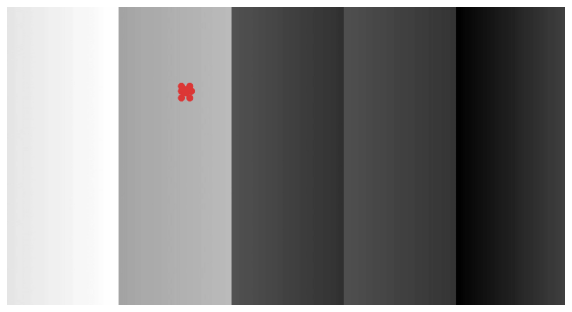

In [203]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB))


In [191]:
print(yuv_image[250, 171])

[163 128 128]
